# 早高峰共享单车潮汐点的群智优化

- 任务一：为更好地掌握早高峰潮汐现象的变化规律与趋势，参赛者需基于主办方提供的数据进行数据分析和计算模型构建等工作，识别出工作日早高峰07:00-09:00潮汐现象最突出的40个区域，列出各区域所包含的共享单车停车点位编号名称，并提供计算方法说明及计算模型，为下一步优化措施提供辅助支撑。

- 任务二：参赛者根据任务一Top40区域计算结果进一步设计高峰期共享单车潮汐点优化方案，通过主动引导停车用户到邻近停车点位停车，进行削峰填谷，缓解潮汐点停车位（如地铁口）的拥堵问题。允许参赛者自带训练数据，但需在参赛作品中说明所自带数据的来源及使用方式，并保证其合法合规。（城市公共自行车从业者将发生在早晚高峰时段共享单车“借不到、还不进”的问题称之为“潮汐”现象。本题涉及的“潮汐现象”聚焦“还不进”的问题，识别出早高峰共享单车最淤积的40个区域）

## 数据说明
- 共享单车轨迹数据：gxdc_gj20201221.csv,gxdc_gj20201222.csv,...,gxdc_gj20201225.csv

- 共享单车停车点数据：gxdc_tcd.csv

- 共享单车订单数据：gxdc_dd.csv

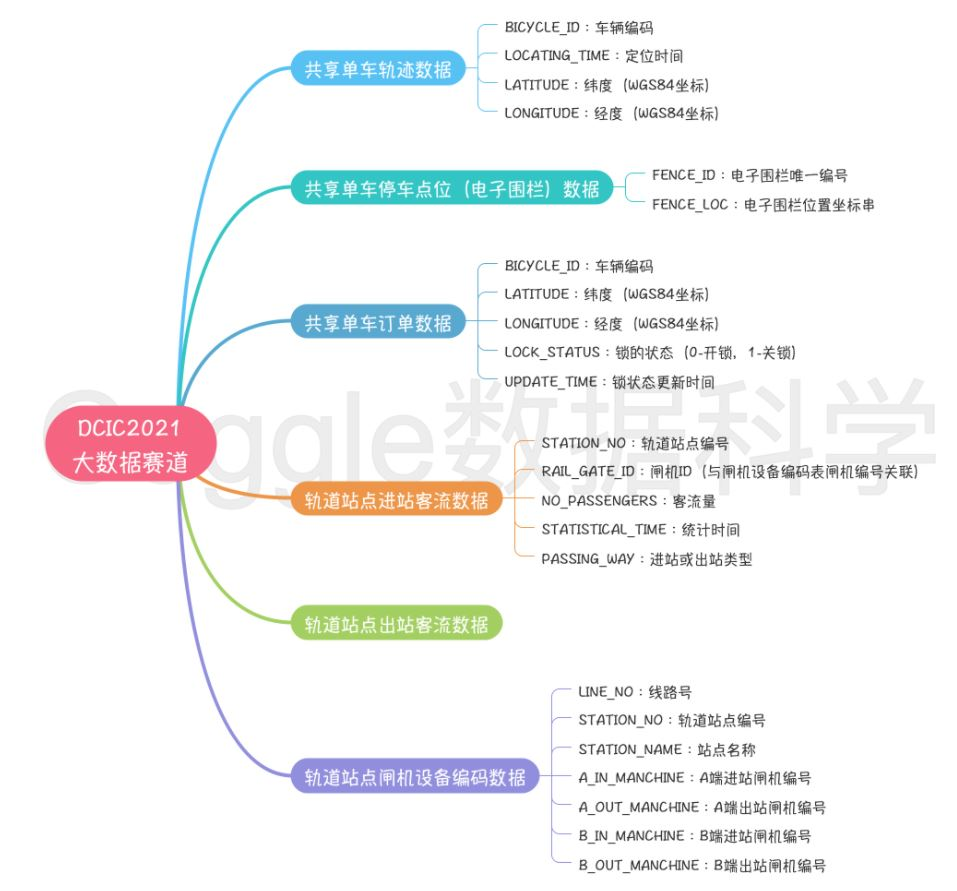

In [1]:
import os,codecs
import pandas as pd
import numpy as np

PATH = './data/'

### 共享单车轨迹数据
共享单车轨迹数据为共享单车在使用时候产生的位置定位数据，具体包含单车在不同时间段（默认是15秒记录一次）下的经纬度信息。

In [ ]:
# 读取共享单车轨迹数据
bike_track = pd.concat([
    pd.read_csv(PATH + 'gxdc_gj20201221.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201222.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201223.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201224.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201225.csv')

])
# 按照单车ID和时间进行排序
bike_track = bike_track.sort_values(['BICYCLE_ID', 'LOCATING_TIME'])

In [4]:
bike_track[:10]

,BICYCLE_ID,LOCATING_TIME,LATITUDE,LONGITUDE,source,LOCATING_TIME1,date,day,time,hour
606925,000152773681a23a7f2d9af8e8902703,2020-12-21 08:17:12,24.499834,118.126603,CSXZGLZFJ,2020-12-21 08:17:12,2020-12-21,21,08:17:12,8
606926,000152773681a23a7f2d9af8e8902703,2020-12-21 08:17:27,24.499483,118.126451,CSXZGLZFJ,2020-12-21 08:17:27,2020-12-21,21,08:17:27,8
606927,000152773681a23a7f2d9af8e8902703,2020-12-21 08:17:42,24.498995,118.126420,CSXZGLZFJ,2020-12-21 08:17:42,2020-12-21,21,08:17:42,8
606928,000152773681a23a7f2d9af8e8902703,2020-12-21 08:17:57,24.498466,118.126352,CSXZGLZFJ,2020-12-21 08:17:57,2020-12-21,21,08:17:57,8
606929,000152773681a23a7f2d9af8e8902703,2020-12-21 08:18:12,24.497911,118.126321,CSXZGLZFJ,2020-12-21 08:18:12,2020-12-21,21,08:18:12,8
606930,000152773681a23a7f2d9af8e8902703,2020-12-21 08:18:27,24.497532,118.126275,CSXZGLZFJ,2020-12-21 08:18:27,2020-12-21,21,08:18:27,8
606931,000152773681a23a7f2d9af8e8902703,2020-12-21 08:18:42,24.497137,118.126298,CSXZGLZFJ,2020-12-21 08:18:42,2020-12-21,21,08:18:42,8
606932,000152773681a23a7f2d9af8e8902703,2020-12-21 08:18:57,24.497120,118.125978,CSXZGLZFJ,2020-12-21 08:18:57,2020-12-21,21,08:18:57,8
606933,000152773681a23a7f2d9af8e8902703,2020-12-21 08:19:14,24.496875,118.125413,CSXZGLZFJ,2020-12-21 08:19:14,2020-12-21,21,08:19:14,8
606934,000152773681a23a7f2d9af8e8902703,2020-12-21 08:19:29,24.496566,118.125322,CSXZGLZFJ,2020-12-21 08:19:29,2020-12-21,21,08:19:29,8


In [5]:
# 路线可视化
import folium
m = folium.Map(location=[24.482426, 118.157606], zoom_start=12)
my_PolyLine=folium.PolyLine(locations=bike_track[bike_track['BICYCLE_ID'] == '000152773681a23a7f2d9af8e8902703'][['LATITUDE', 'LONGITUDE']].values,weight=5)
m.add_children(my_PolyLine)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  """


### 共享单车停车点位（电子围栏）数据
共享单车停车点位（电子围栏）数据为规范共享单车停车秩序，统一划定的共享单车停放区域。

In [2]:
# 读取共享单车停车点位（电子围栏）数据
def bike_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s

# 共享单车停车点位（电子围栏）数据
bike_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)

In [61]:
bike_fence['FENCE_LOC'][:10]

0    [[118.103198, 24.527338], [118.103224, 24.5273...
1    [[118.103171, 24.527303], [118.103198, 24.5273...
2    [[118.103231, 24.527386], [118.103257, 24.5274...
3    [[118.103257, 24.527421], [118.103282, 24.5274...
4    [[118.102948, 24.527003], [118.102979, 24.5270...
5    [[118.102916, 24.526957], [118.102937, 24.5269...
6    [[118.102582, 24.526509], [118.102608, 24.5265...
7    [[118.102659, 24.526608], [118.102682, 24.5266...
8    [[118.102691, 24.526649], [118.102714, 24.5266...
9    [[118.102722, 24.526689], [118.102745, 24.5267...
Name: FENCE_LOC, dtype: object

### 共享单车订单数据
共享单车订单数据为共享单车使用时开锁和关锁信息的数据。

In [3]:
# 读取共享单车订单数据
bike_order = pd.read_csv(PATH + 'gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [4]:
bike_order[:10]

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020/12/21 6:32:48
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020/12/21 6:50:18
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020/12/21 8:23:32
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020/12/21 8:44:34
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020/12/22 8:00:44
118909,0000ff105fd5f9099b866bccd157dc50,24.494801,118.147564,1,2020/12/22 8:14:57
148850,0000ff105fd5f9099b866bccd157dc50,24.494648,118.147526,0,2020/12/22 8:19:35
96851,0000ff105fd5f9099b866bccd157dc50,24.491365,118.149005,1,2020/12/22 8:23:24
118000,0000ff105fd5f9099b866bccd157dc50,24.491301,118.149002,0,2020/12/22 8:50:25
155763,0000ff105fd5f9099b866bccd157dc50,24.493236,118.141339,1,2020/12/22 8:54:24


## 经纬度匹配
通过将订单中车辆的经纬度与具体的停车点进行匹配，计算不同时间点每个停车点的单车流量。

### 停车点处理
计算每个停车点的面积和中心经纬度

In [5]:
# 得出停车点 LATITUDE 范围
bike_fence['MIN_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
bike_fence['MAX_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

# 得到停车点 LONGITUDE 范围
bike_fence['MIN_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
bike_fence['MAX_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

from geopy.distance import geodesic
# 根据停车点 范围 计算具体的面积
bike_fence['FENCE_AREA'] = bike_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

# 根据停车点 计算中心经纬度
bike_fence['FENCE_CENTER'] = bike_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

In [6]:
bike_fence[:10]

,FENCE_ID,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...",24.527331,24.527373,118.103198,118.103236,6.039052,"[24.527352, 118.10321675]"
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...",24.527296,24.527338,118.103171,118.103209,6.039053,"[24.527317000000004, 118.10319]"
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...",24.527378,24.527421,118.103231,118.103270,6.188997,"[24.527399499999998, 118.1032505]"
3,长乐路0_L_A17004,"[[118.103257, 24.527421], [118.103282, 24.5274...",24.527413,24.527455,118.103257,118.103295,6.039051,"[24.527434, 118.10327600000001]"
4,长乐路0_L_A17005,"[[118.102948, 24.527003], [118.102979, 24.5270...",24.526995,24.527046,118.102948,118.102992,7.196632,"[24.5270205, 118.10297]"
5,长乐路0_L_A17006,"[[118.102916, 24.526957], [118.102937, 24.5269...",24.526949,24.526990,118.102916,118.102951,5.762216,"[24.5269695, 118.10293325]"
6,长乐路0_L_A17007,"[[118.102582, 24.526509], [118.102608, 24.5265...",24.526502,24.526542,118.102582,118.102619,5.804143,"[24.526522, 118.10260075000001]"
7,长乐路0_L_A17008,"[[118.102659, 24.526608], [118.102682, 24.5266...",24.526601,24.526638,118.102659,118.102694,5.419893,"[24.52661925, 118.1026765]"
8,长乐路0_L_A17009,"[[118.102691, 24.526649], [118.102714, 24.5266...",24.526641,24.526678,118.102691,118.102725,5.354130,"[24.526659749999997, 118.102708]"
9,长乐路0_L_A17010,"[[118.102722, 24.526689], [118.102745, 24.5267...",24.526682,24.526719,118.102722,118.102756,5.354130,"[24.526700249999998, 118.102739]"


### Geohash经纬度匹配

In [45]:
import geohash
bike_order['geohash'] = bike_order.apply(
    lambda x: geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=7), axis=1)

bike_fence['geohash'] = bike_fence['FENCE_CENTER'].apply(
    lambda x: geohash.encode(x[0], x[1], precision=7))

In [46]:
bike_order[:10]

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,geohash,DAY,HOUR,DAY_HOUR
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,wsk52rgnn,21,06,2106
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,wsk527kyb,21,06,2106
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,wsk527kyf,21,08,2108
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,wsk52bwyn,21,08,2108
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,wsk52ty4b,22,08,2208
118909,0000ff105fd5f9099b866bccd157dc50,24.494801,118.147564,1,2020-12-22 08:14:57,wsk52e0kt,22,08,2208
148850,0000ff105fd5f9099b866bccd157dc50,24.494648,118.147526,0,2020-12-22 08:19:35,wsk52e07s,22,08,2208
96851,0000ff105fd5f9099b866bccd157dc50,24.491365,118.149005,1,2020-12-22 08:23:24,wsk52d92x,22,08,2208
118000,0000ff105fd5f9099b866bccd157dc50,24.491301,118.149002,0,2020-12-22 08:50:25,wsk52d92p,22,08,2208
155763,0000ff105fd5f9099b866bccd157dc50,24.493236,118.141339,1,2020-12-22 08:54:24,wsk526ggk,22,08,2208


## 区域流量与潮汐统计

In [7]:
# 对订单数据进行时间提取
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])
bike_order['DAY'] = bike_order['UPDATE_TIME'].dt.day.astype(object)
bike_order['DAY'] = bike_order['DAY'].apply(str)

bike_order['HOUR'] = bike_order['UPDATE_TIME'].dt.hour.astype(object)
bike_order['HOUR'] = bike_order['HOUR'].apply(str)
bike_order['HOUR'] = bike_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

# 日期和时间进行拼接
bike_order['DAY_HOUR'] = bike_order['DAY'] + bike_order['HOUR']

In [69]:
bike_order[:10]

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,fence,DAY,HOUR,DAY_HOUR
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,前埔中二路 _R_4,21,06,2106
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,文兴西路0_L_B29006,21,06,2106
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,文兴西路0_L_B29006,21,08,2108
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,育秀中路(育秀东路至育秀路段)_L_3,21,08,2108
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,演武路0_L_A11006,22,08,2208
118909,0000ff105fd5f9099b866bccd157dc50,24.494801,118.147564,1,2020-12-22 08:14:57,云顶北路_L_B27015,22,08,2208
148850,0000ff105fd5f9099b866bccd157dc50,24.494648,118.147526,0,2020-12-22 08:19:35,云顶北路_L_B27015,22,08,2208
96851,0000ff105fd5f9099b866bccd157dc50,24.491365,118.149005,1,2020-12-22 08:23:24,东浦路_L_16,22,08,2208
118000,0000ff105fd5f9099b866bccd157dc50,24.491301,118.149002,0,2020-12-22 08:50:25,东浦路_L_16,22,08,2208
155763,0000ff105fd5f9099b866bccd157dc50,24.493236,118.141339,1,2020-12-22 08:54:24,东渡路_L_20,22,08,2208


## 方法1：Geohash匹配计算潮汐

In [49]:
# 统计每个区域在不同时间的入流量和出流量
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

In [50]:
# 根据入流量和出流量，可以计算得到每个位置的留存流量
bike_remain = (bike_inflow - bike_outflow).fillna(0)
# 存在骑走的车数量 大于 进来的车数量
bike_remain[bike_remain < 0] = 0  
# 按照天求平均
bike_remain = bike_remain.sum(1)
bike_fence['DENSITY'] = bike_fence['geohash'].map(bike_remain).fillna(0)

In [51]:
bike_fence = bike_fence.sort_values(['DENSITY'],ascending=False)

In [52]:
bike_fence

,FENCE_ID,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,DENSITY
9823,环岛干道(钟宅路至五缘湾道)_L_17,"[[118.1626022376, 24.5345126372], [118.1625560...",24.534513,24.534583,118.162556,118.162616,9.939719,"[24.53454798665, 118.16258628770001]",wsk58f7k5,43.0
11435,观日路0_R_1,"[[118.176620421, 24.4871245097], [118.17662004...",24.487106,24.487125,118.176576,118.176620,5.020113,"[24.48711584215, 118.17659807925]",wsk531txf,41.0
2410,创新路(马垅路至火炬路段)_L_3,"[[118.1210691142, 24.5197375805], [118.1210410...",24.519738,24.519802,118.121041,118.121085,8.380898,"[24.5197696561, 118.12106296350001]",ws7grztnh,41.0
2464,前埔东路_R_1,"[[118.1765358314, 24.4871082404], [118.1764808...",24.487074,24.487121,118.176472,118.176536,8.304078,"[24.4870973355, 118.17650373250001]",wsk531tx8,34.0
554,云顶中路0_L_A03003,"[[118.148424, 24.490552], [118.148431, 24.4905...",24.490518,24.490566,118.148424,118.148514,10.558871,"[24.49054175, 118.148469]",wsk52d35d,32.0
553,云顶中路0_L_A03002,"[[118.1485, 24.490504], [118.148417, 24.490538...",24.490504,24.490552,118.148417,118.148507,10.558872,"[24.490528000000005, 118.148462]",wsk52d35d,32.0
7193,枋钟路0_R_5,"[[118.126451156, 24.5297534318], [118.12641430...",24.529724,24.529765,118.126403,118.126451,6.669703,"[24.529744632750003, 118.126427292]",wsk581901,27.0
2413,创新路(马垅路至火炬路)_R_3,"[[118.1217152281, 24.5191415156], [118.1216713...",24.519084,24.519150,118.121658,118.121715,9.328606,"[24.5191173621, 118.12168650225]",ws7grztd4,27.0
1132,仙岳路0_L_53,"[[118.122465014, 24.5022638442], [118.12235761...",24.502216,24.502278,118.122350,118.122465,13.520467,"[24.502246627799998, 118.12240761799998]",ws7gruqpg,26.0
2615,前埔路 _R_3,"[[118.1685029786, 24.4847229169], [118.1684904...",24.484675,24.484727,118.168473,118.168503,6.419153,"[24.48470104915, 118.16848820335001]",wsk52cr9t,26.0


## 方法2：距离匹配计算潮汐

In [9]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric = "haversine", n_jobs=-1, algorithm='auto')
knn.fit(np.stack(bike_fence['FENCE_CENTER'].values))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='haversine',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [10]:
dist, index = knn.kneighbors(bike_order[['LATITUDE','LONGITUDE']].values[:], n_neighbors=1)

In [11]:
bike_order['fence'] = bike_fence.iloc[index.flatten()]['FENCE_ID'].values

In [66]:
bike_order[:10]

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,fence
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020/12/21 6:32:48,前埔中二路 _R_4
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020/12/21 6:50:18,文兴西路0_L_B29006
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020/12/21 8:23:32,文兴西路0_L_B29006
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020/12/21 8:44:34,育秀中路(育秀东路至育秀路段)_L_3
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020/12/22 8:00:44,演武路0_L_A11006
118909,0000ff105fd5f9099b866bccd157dc50,24.494801,118.147564,1,2020/12/22 8:14:57,云顶北路_L_B27015
148850,0000ff105fd5f9099b866bccd157dc50,24.494648,118.147526,0,2020/12/22 8:19:35,云顶北路_L_B27015
96851,0000ff105fd5f9099b866bccd157dc50,24.491365,118.149005,1,2020/12/22 8:23:24,东浦路_L_16
118000,0000ff105fd5f9099b866bccd157dc50,24.491301,118.149002,0,2020/12/22 8:50:25,东浦路_L_16
155763,0000ff105fd5f9099b866bccd157dc50,24.493236,118.141339,1,2020/12/22 8:54:24,东渡路_L_20


In [12]:
# 计算所有停车点的潮汐流量
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)

In [13]:
bike_remain

fence
七星西路0_L_1            25.0
七星西路0_L_2             4.0
七星西路0_L_3             0.0
七星西路0_R_1             3.0
七星西路0_R_2             8.0
七星西路0_R_3            24.0
七星西路_L_1             10.0
七星西路_L_2_A            6.0
七星西路_L_2_B           33.0
七星西路_L_3_A           17.0
七星西路_L_3_B           21.0
七星西路_L_4_A           14.0
七星西路_L_4_B            5.0
七星西路_L_5_A            2.0
七星西路_L_5_B            1.0
七星西路_L_6              4.0
七星西路_L_7              0.0
七星西路_R_1_A            5.0
七星西路_R_1_B           10.0
七星西路_R_2_A            5.0
七星西路_R_2_B            8.0
七星西路_R_3_A            0.0
七星西路_R_3_B            7.0
七星西路_R_4             29.0
七星西路_R_5             32.0
七星路(体育路至湖滨北路)_L_1     3.0
七星路(体育路至湖滨北路)_L_2     1.0
七星路(体育路至湖滨北路)_L_3    32.0
七星路(体育路至湖滨北路)_L_4    20.0
七星路(体育路至湖滨北路)_L_5     3.0
                     ... 
龙虎山路_L_A06011         5.0
龙虎山路_R_10             0.0
龙虎山路_R_11             0.0
龙虎山路_R_12             0.0
龙虎山路_R_13             3.0
龙虎山路_R_14             0.0
龙虎山路_R_15             2.0
龙虎山路_R

In [14]:
# 计算停车点的密度
bike_density = bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']
bike_density = bike_density.sort_values(ascending=False).reset_index()
bike_density = bike_density.fillna(0)

In [15]:
bike_density

,index,0
0,观日路(望海路至会展路段 )_R_1,132.054140
1,象屿路0_R_1,100.175756
2,望海路0_R_2,79.024606
3,望海路0_R_1,65.889561
4,云顶北路0_R_45,52.407645
5,前埔东路_R_1,46.964878
6,云顶中路0_L_4,46.516229
7,云顶中路0_L_A03002,41.576411
8,望海路0_L_1,40.588678
9,龙伏路0_L_4,36.273850


In [16]:
bike_density['label'] = '0'
bike_density.iloc[:40, -1] = '1'

bike_density['BELONG_AREA'] ='厦门'
bike_density = bike_density.drop(0, axis=1)

In [17]:
bike_density.columns = ['FENCE_ID', 'FENCE_TYPE', 'BELONG_AREA']

In [18]:
bike_density.to_csv('./result.txt', index=None, sep='|')